## Planned Experiments

1. Model LR with n-gram (bow) weigted by TF-IDF and apply individual dataset seperatly
2. Apply LR with n-gram (bow) weigted by TF-IDF and apply to gossip + kaggle datasets
3. Apply LR with n-gram (bow) weigted by TF-IDF and apply to gossip + Sinhala_singlish datasets
4. Apply LR with n-gram (bow) weigted by TF-IDF and apply to gossip + Twiiter datasets

Datasets distribution  statistical analysis

Dtaaset length didtribution

Next step -> check same LR model with word2vec or any embedding techniques

Next step -> check datasets with Deep learning model 

## Setup Experimnet settings with Neptune 

In [1]:
import neptune
from neptunecontrib.monitoring.metrics import expand_prediction, log_class_metrics, log_binary_classification_metrics, log_classification_report,log_confusion_matrix,log_prediction_distribution
import os
from dotenv import load_dotenv

load_dotenv()
NEPTUNE_PROJECT= os.getenv('NEPTUNE_PROJECT')
NEPTUNE_API_TOKEN = os.getenv(('NEPTUNE_API_TOKEN'))
neptune.init(project_qualified_name= NEPTUNE_PROJECT,api_token=NEPTUNE_API_TOKEN) 
             

Project(codekcg23/Research-Experiments)

## Import modules

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report
#from sklearn.metrics import accuracy_score, f1_score, precision_score,roc_curve,roc_auc_score,confusion_matrix,recall_score
#from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import re
import gensim

# import helper function script
import sys
sys.path.insert(1,'G:\\Github\\Sinhala-Hate-Speech-Detection')
import utills

## Read datasets to dataframes

In [2]:
df_A = pd.read_csv ('../Datasets/raw/gossip_dataset_complete_v0.csv',header =None)

df_B = pd.read_csv('../Datasets/raw/kaggle_dataset.csv')    # fb dataset -kaggle

df_C = pd.read_csv('../Datasets/raw/twitter_dataset.csv')    # multiple_domain dataset
#print(df_C.head())
df_D =  pd.read_csv('../Datasets/raw/Sinhala_Singlish_Hate_Speech.csv')   # Twitter dataset -github
#df_D.head(n=20)

## Check correctness of preprocessing functions

In [4]:
d=utills.removeEnglishWords('Ai සපෝර්ට්')
print(d)
g = utills.removeMention('@uilknk @සපෝර්ට් හොදනම්@ ')
print(g)
c= utills.removeUrl('හොදනම්  https://stackoverflow.com/questions/4987327/how-do-i-check-if-a-string-is-unicode-or-ascii සපෝර්ට්https://stackoverflow.com/questions/4987327/how-do-i-check-if-a-string-is-unicode-or-ascii')
print(c)
d = utills.removeRetweetState('RT @හොදනම් RT @jkl')
print(d)
s = utills.removePunctuation(' වැඩ?-)^  ^ හොදනම්?')
print(s)
a = utills.removeNumber('34 හොදනම්34 2හොදනම්')
print(a)
q = utills.removeEmoji(' 😫හොදනම් 🚗🚉ᓚᘏᗢ:-):-)^_^(*/ω＼*)(^///^):-Dಥ_ಥ༼ つ ◕_◕ ༽つ¯\_(ツ)_/¯(❁´◡`❁)😚😚😚😎')
print(q)

## Prepare datasets for experiments

In [3]:
# Make same columns and labels give new col representing dataset
df_A.columns = ['comment','label']  # gossip dataset
#drop columns
df_B.drop('id',axis=1,inplace=True)
df_C.drop(['instance_id','id','user.id','created_at'],axis=1,inplace=True)
df_C.columns = ['comment','label']       # change text => comment class to 'label
#print(df_C.head())
df_D.drop('PhraseNo',axis=1,inplace=True)
df_D.columns = ['comment','label']       # change Phrase => comment IsHateSpeech to 'label
#print(df_D.head())
#map column
map_dict_C = {'Neutral':0,'Sexism':1,'Racist':1}
df_C['label'].replace(map_dict_C,inplace=True)

df_D = utills.removeSentenceContainsEnglish(df_D,'comment')
map_dict_D = {'YES':1,'NO':0}
df_D['label'].replace(map_dict_D,inplace=True)

# add column to identify datasets
df_A['df'] ='A'
df_B['df'] ='B'
df_C['df'] ='C'
df_D['df'] ='D'


Input dataframe size =  2500
Cleaned dataframe size - removed Strings contain Englishs letters  1446


## Make pair of datsets

In [4]:
df_A_B = df_A.append(df_B,ignore_index=True)
df_A_C = df_A.append(df_C,ignore_index=True)
df_A_D = df_A.append(df_D,ignore_index=True)
df_A_C_D = df_A.append([df_C,df_D],ignore_index=True)
df_A_B_C = df_A.append([df_B,df_C],ignore_index=True)
df_A_B_D = df_A.append([df_B,df_D],ignore_index=True)
df_B_C_D = df_B.append([df_C,df_D],ignore_index=True)
df_all =  df_A.append([df_B,df_C,df_D],ignore_index=True)
print('A and B',len(df_A_B))
print('A and C',len(df_A_C))
print('A and D',len(df_A_D))
print('A,B,C',len(df_A_B_C))
print('A,B,D',len(df_A_B_D))
print('A,C,D ',len(df_A_C_D))
print('A,B,C,D all datasets',len(df_all))

df_A_B.head()

A and B 12813
A and C 7879
A and D 7914
A,B,C 14224
A,B,D 14259
A,C,D  9325
A,B,C,D all datasets 15670


,comment,label,df
0,මේ වේසිට නීතිය ක්‍රියාත්මක වෙන්නෙ කවදාද ?,1,A
1,තූ ෙනදකින්,1,A
2,අම්මා ලුසීඩා කියුවම මට හිතෙන්නම ෆලූඩා කියලා. හ...,0,A
3,දින ඒකාබද්ධ විපක්ෂයේ මාධ්‍ය ලේකම් රේණුක පෙරේරා...,0,A
4,පූදින්ෙන නැතුව ඉදිං,1,A


In [10]:
# dataset name list
import os
folder_path = 'G:\\Github\\Sinhala-Hate-Speech-Detection\\Datasets\\processed\\no_preprocessing\\'
df_dict = {'df_A': df_A,'df_B': df_B,'df_C' :df_C,'df_D' :df_D,'df_A_B' :df_A_B,'df_A_C' :df_A_C,'df_A_D' :df_A_D,'df_A_C_D':df_A_C_D,'df_A_B_C':df_A_B_C,'df_A_B_D':df_A_B_D,'df_B_C_D':df_B_C_D,'df_all':df_all}
for name,df in df_dict.items():
    print(os.path.join(folder_path,f'{name}.csv'))
    df.to_csv(os.path.join(folder_path,f'{name}.csv'), index=False)

G:\Github\Sinhala-Hate-Speech-Detection\Datasets\processed\no_preprocessing\df_A.csv
G:\Github\Sinhala-Hate-Speech-Detection\Datasets\processed\no_preprocessing\df_B.csv
G:\Github\Sinhala-Hate-Speech-Detection\Datasets\processed\no_preprocessing\df_C.csv
G:\Github\Sinhala-Hate-Speech-Detection\Datasets\processed\no_preprocessing\df_D.csv
G:\Github\Sinhala-Hate-Speech-Detection\Datasets\processed\no_preprocessing\df_A_B.csv
G:\Github\Sinhala-Hate-Speech-Detection\Datasets\processed\no_preprocessing\df_A_C.csv
G:\Github\Sinhala-Hate-Speech-Detection\Datasets\processed\no_preprocessing\df_A_D.csv
G:\Github\Sinhala-Hate-Speech-Detection\Datasets\processed\no_preprocessing\df_A_C_D.csv
G:\Github\Sinhala-Hate-Speech-Detection\Datasets\processed\no_preprocessing\df_A_B_C.csv
G:\Github\Sinhala-Hate-Speech-Detection\Datasets\processed\no_preprocessing\df_A_B_D.csv
G:\Github\Sinhala-Hate-Speech-Detection\Datasets\processed\no_preprocessing\df_B_C_D.csv
G:\Github\Sinhala-Hate-Speech-Detection\Dat

## Helper functions

### preprocessing

In [6]:
def prepare_dataset(df,name):
    df = utills.preprocess(df,'comment')
    print(name,len(df))
    X_train,X_test,Y_train,Y_test = train_test_split(df['cleaned'],df['label'], test_size=0.3, random_state=0,stratify=df['label'].values)
    print("X train {} Y train {} X test {} Y test {}".format(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape))
    return (X_train,X_test,Y_train,Y_test)
    

### Models

In [7]:
def LR(X_train,X_test,Y_train,vectorizer,feature_name):
    #X_train,X_test,Y_train,Y_test = prepare_dataset(df,'comment')
    lr = LogisticRegression()
    lr_pipe = Pipeline([(feature_name, vectorizer), ('lr', lr)])

    lr_pipe.fit(X_train, Y_train)

    #predictions
    Y_pred = lr_pipe.predict(X_test)
    return (lr_pipe, Y_pred)

In [8]:
def result(y_test, y_pred):
    import sklearn.metrics as metrics
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    classes = np.unique(y_test)
    #y_test_array = pd.get_dummies(y_test, drop_first=False).values
    ## Accuracy, Precision, Recall
    accuracy = metrics.accuracy_score(y_test, y_pred)
    auc = metrics.roc_auc_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1_score = metrics.f1_score(y_test, y_pred)
    print("Accuracy:",  round(accuracy, 2))
    print("Auc:", round(auc, 2))
    print("Precsion:", round(precision, 2))
    print("f1_score:", round(f1_score, 2))
    print("recall:", round(recall, 2))
    print("Detail:")
    print(metrics.classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(xlabel="Predicted", ylabel="Actual", xticklabels=classes,
           yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)
    plt.show()
    utills.PlotRocAuc(y_test, y_pred, 'green', 'LR')
    # fig, ax = plt.subplots(nrows=1, ncols=2)
    # # Plot roc
    
    # fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    # ax[0].plot(fpr, tpr, lw=3,
    #                label='{0} (area={1:0.2f})'.format(
    #                    'LR', metrics.auc(fpr, tpr))
    #                )
    # ax[0].plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
    # ax[0].set(xlim=[-0.05, 1.0], ylim=[0.0, 1.05],
    #           xlabel='False Positive Rate',
    #           ylabel="True Positive Rate (Recall)",
    #           title="Receiver operating characteristic")
    # ax[0].legend(loc="lower right")
    # ax[0].grid(True)

    # # Plot precision-recall curve
    
    # precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred)
    # ax[1].plot(recall, precision, lw=3, label='LR (area={1:0.2f})'.format( metrics.auc(recall, precision)))
    # ax[1].set(xlim=[0.0, 1.05], ylim=[0.0, 1.05], xlabel='Recall',
    #           ylabel="Precision", title="Precision-Recall curve")
    # ax[1].legend(loc="best")
    # ax[1].grid(True)
    # plt.show()
    return (accuracy, f1_score, recall, precision, auc)

In [12]:


def log_result(Y_test,Y_pred,feature_name,df_name,final_result):
    
    
    print("========= Eperiment - ",df_name,' - ', feature_name," =========")
    neptune.create_experiment(df_name+feature_name)
    neptune.append_tag(['Dataset experiment 3',df_name,feature_name])
    # #print(Y_pred.type)
    # print(Y_test.shape,Y_pred.shape)
    log_class_metrics(Y_test, Y_pred)
    # #log_prediction_distribution(Y_test, Y_pred)
    log_confusion_matrix(Y_test, Y_pred)
    log_classification_report(Y_test, Y_pred)
    accuracy,f1_score,recall,precision,auc = result(Y_test,Y_pred)
    neptune.log_metric('acc', accuracy)
    neptune.log_metric('auc', auc)
    neptune.log_metric('recall', recall)
    neptune.log_metric('precison', precision)
    neptune.log_metric('f1_score', f1_score)
    #log_binary_classification_metrics(Y_test, expand_prediction(Y_pred))
    
    final_result.loc[df_name] = [accuracy,f1_score,recall,precision,auc]
    #report = classification_report(Y_test, Y_pred)
    #print(report)
    #result_df = pd.DataFrame(report).transpose()
    #print(result_df)
    return final_result
    

## Dataset Details view

In [8]:
# load datasets
path = '../Datasets/processed/no_preprocessing/'
df_A = pd.read_csv(path+'df_A.csv')    
df_B = pd.read_csv(path+'df_B.csv')    # fb dataset -kaggle
df_C = pd.read_csv(path+'df_C.csv') 
df_D = pd.read_csv(path+'df_D.csv') 
df_A_B = pd.read_csv(path+'df_A_B.csv') 
df_A_C = pd.read_csv(path+'df_A_C.csv') 
df_A_D = pd.read_csv(path+'df_A_D.csv') 
df_A_B_C = pd.read_csv(path+'df_A_B_C.csv') 
df_A_C_D = pd.read_csv(path+'df_A_C_D.csv') 
df_A_B_D = pd.read_csv(path+'df_A_B_D.csv') 
df_all = pd.read_csv(path+'df_all.csv') 

In [3]:
# dataset name list
df_dict = {'df_A': df_A,'df_B': df_B,'df_C' :df_C,'df_D' :df_D,'df_A_B' :df_A_B,'df_A_C' :df_A_C,'df_A_D' :df_A_D,'df_A_C_D':df_A_C_D,'df_A_B_C':df_A_B_C,'df_A_B_D':df_A_B_D,'df_all':df_all}

### reason to word count get increase after preprocessing

In [49]:
df_A.cleaned.str.split().tail()

6463       [මුගෙ, එක, කනක්, පොඩියි, උඹලා, දැකලා, තියෙනවද]
6464     [කවුද, බං, මේ, කෑල්ල, ෆොටෝවක්, නැද්ද, කා, ලගවත්]
6465    [මරා, ෂැන්ඩි, නැතුවලු, දැන්, බොන්නෙ, ඉක්මනට, ර...
6466    [චතුරිකාට, වඩා, නංගි, කෙල්ල, ලස්සනයි, මාමගෙන්,...
6467    [ඉතිං, අපි, මොනවද, කියන්න, ඕනෙ, සාරාංග, කියන්න...
Name: cleaned, dtype: object

In [50]:
df_A.comment.str.split().tail()

6463    [මුගෙ, එක, කනක්, පොඩියි...උඹලා, දැකලා, තියෙනවද...
6464    [කවුද, බං, මේ, කෑල්ල...ෆොටෝවක්, නැද්ද, කා, ලගව...
6465    [මරා, ෂැන්ඩි, නැතුවලු, දැන්, බොන්නෙ...ඉක්මනට, ...
6466    [චතුරිකාට, වඩා, නංගි, කෙල්ල, ලස්සනයි...මාමගෙන්...
6467    [ඉතිං, අපි, මොනවද, කියන්න, ඕනෙ...සාරාංග, කියන්...
Name: comment, dtype: object

In [9]:
# dataset details
def dataset_details(df_list):
    details_df = pd.DataFrame(columns=['Size','Hate (1) %','Non hate (0) %','Unique words #','Words #','Avg comment length'])
    for name,df in df_list.items():
        df = utills.preprocess(df,'comment')
        size = len(df)
        hate = round(((df.label==1).sum()/size)*100,2)
        non_hate = round(((df.label==0).sum()/size)*100,2)
        from collections import Counter
        results = Counter()
        words = df.cleaned.apply(lambda x :len(x.split())).sum(axis=0)
        df['cleaned'].str.split().apply(results.update)
        unique_words = len(results)
        #df.cleaned.apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0)
        avg_comment_length = round(df.cleaned.apply(lambda x :len(x.split())).sum(axis=0)/len(df),2)
        details_df.loc[name]=[size,hate,non_hate,unique_words,words,avg_comment_length]
    return details_df       
        



In [35]:
## without preprocessing
dataset_details(df_dict)

,Size,Hate (1) %,Non hate (0) %,Unique words #,Words #,Avg comment length
df_A,6468.0,31.11,68.89,28924.0,98560.0,15.24
df_B,6345.0,54.45,45.55,22464.0,76832.0,12.11
df_C,1411.0,23.39,76.61,10993.0,23758.0,16.84
df_D,1446.0,45.85,54.15,10762.0,25738.0,17.80
df_A_B,12813.0,42.67,57.33,44931.0,175392.0,13.69
df_A_C,7879.0,29.72,70.28,33675.0,122318.0,15.52
df_A_D,7914.0,33.80,66.20,34906.0,124298.0,15.71
df_A_C_D,9325.0,32.23,67.77,39478.0,148056.0,15.88
df_A_B_C,14224.0,40.76,59.24,49355.0,199150.0,14.00
df_A_B_D,14259.0,42.99,57.01,50004.0,201130.0,14.11


In [38]:
## with preprocessing
dataset_details(df_dict)

,Size,Hate (1) %,Non hate (0) %,Unique words #,Words #,Avg comment length
df_A,6468.0,31.11,68.89,22118.0,100268.0,15.50
df_B,6345.0,54.45,45.55,18637.0,78309.0,12.34
df_C,1411.0,23.39,76.61,8579.0,24407.0,17.30
df_D,1446.0,45.85,54.15,9338.0,26177.0,18.10
df_A_B,12813.0,42.67,57.33,34260.0,178577.0,13.94
df_A_C,7879.0,29.72,70.28,24690.0,124675.0,15.82
df_A_D,7914.0,33.80,66.20,26611.0,126445.0,15.98
df_A_C_D,9325.0,32.23,67.77,29020.0,150852.0,16.18
df_A_B_C,14224.0,40.76,59.24,36508.0,202984.0,14.27
df_A_B_D,14259.0,42.99,57.01,37906.0,204754.0,14.36


In [27]:
## earlier one
dataset_details(df_dict)

,size,hate (1),non hate (0),unique words,avg comment length
df_A,6468.0,31.106988,68.893012,22118.0,21.079623
df_B,6345.0,54.452325,45.547675,18637.0,14.611348
df_C,1411.0,23.387668,76.612332,8579.0,24.204111
df_D,1446.0,45.850622,54.149378,9338.0,21.408022
df_A_B,12813.0,42.667603,57.332397,34260.0,17.876532
df_A_C,7879.0,29.724584,70.275416,24690.0,21.639167
df_A_D,7914.0,33.800859,66.199141,26611.0,21.139626
df_A_C_D,9325.0,32.225201,67.774799,29020.0,21.603324
df_A_B_C,14224.0,40.755062,59.244938,36508.0,18.504218
df_A_B_D,14259.0,42.990392,57.009608,37906.0,18.234659


## Distribution of classes in datasest

In [10]:
# to visualize distribution of A, B and B
dataset_details({'df_A': df_A,'df_B': df_B,'df_A_B' :df_A_B})

,Size,Hate (1) %,Non hate (0) %,Unique words #,Words #,Avg comment length
df_A,6468.0,31.11,68.89,22340.0,100265.0,15.50
df_B,6345.0,54.45,45.55,18638.0,78309.0,12.34
df_A_B,12813.0,42.67,57.33,34496.0,178574.0,13.94


             label  word_length
count  6468.000000  6468.000000
mean      0.311070    15.501701
std       0.462967    13.715239
min       0.000000     0.000000
25%       0.000000     7.000000
50%       0.000000    11.000000
75%       1.000000    20.000000
max       1.000000   118.000000


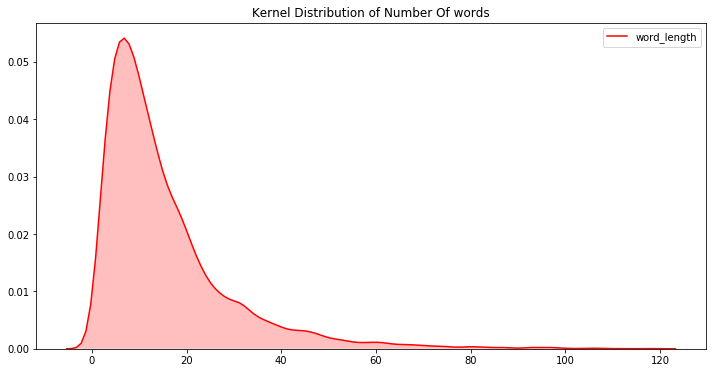

In [14]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
df = df_A.copy()
df['word_length'] = df['cleaned'].apply(lambda x: len(str(x).split())) 
print(df.describe())
#articles_word_limit = articles_nonNull[articles_nonNull[‘word_length’] > 60]
plt.figure(figsize=(12,6))
p1=sns.kdeplot(df['word_length'], shade=True, color="r").set_title("Kernel Distribution of Number Of words")

Number of words

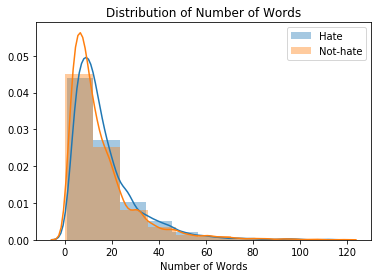

In [15]:

hate_length = [df[df.label.values == 1].word_length.values]
not_hate_length = [df[df.label.values == 0].word_length.values]
#not_clickbait_length = [len(word_tokenize(title)) for title in train[train.label.values != 'clickbait'].title.values]

sns.distplot(hate_length, bins = 10, label = 'Hate')
sns.distplot(not_hate_length, bins = 10, label = 'Not-hate')
plt.legend()
plt.title('Distribution of Number of Words')
plt.xlabel('Number of Words')
plt.show()

### Mean word length

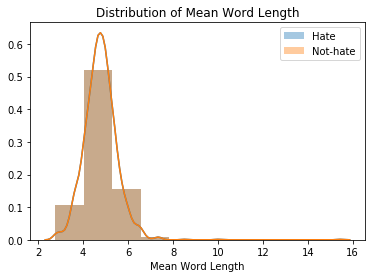

In [19]:
import numpy as np
def mean_word_length(x):
    word_lengths = np.array([])
    for word in x.split():
        word_lengths = np.append(word_lengths, len(word))
    return word_lengths.mean()


hate_mean_length = df[df.label.values == 1].cleaned.apply(mean_word_length)
not_hate__mean_length = df[df.label.values == 0].cleaned.apply(mean_word_length)


sns.distplot(hate_mean_length, bins = 10, label = 'Hate')
sns.distplot(hate_mean_length, bins = 10, label = 'Not-hate')
plt.title('Distribution of Mean Word Length')
plt.xlabel('Mean Word Length')
plt.legend()

In [27]:
def visualize_df_class(df_dict):
    for name,df in df_dict.items():
        print("Dataset - ",name)
        df = df.copy()
        df['word_length'] = df['cleaned'].apply(lambda x: len(str(x).split())) 
        print(df.describe())
        #articles_word_limit = articles_nonNull[articles_nonNull[‘word_length’] > 60]
        plt.figure(figsize=(10,5))
        p1=sns.kdeplot(df['word_length'], shade=True, color="r").set_title("Kernel Distribution of Number Of words")
        hate_length = [df[df.label.values == 1].word_length.values]
        not_hate_length = [df[df.label.values == 0].word_length.values]
        #not_clickbait_length = [len(word_tokenize(title)) for title in train[train.label.values != 'clickbait'].title.values]
        plt.show()
        
        sns.distplot(hate_length, bins = 10, label = 'Hate')
        sns.distplot(not_hate_length, bins = 10, label = 'Not-hate')
        plt.legend()
        plt.title('Distribution of Number of Words')
        plt.xlabel('Number of Words')
        plt.show()

        # mean word length
        hate_mean_length = df[df.label.values == 1].cleaned.apply(mean_word_length)
        not_hate__mean_length = df[df.label.values == 0].cleaned.apply(mean_word_length)


        sns.distplot(hate_mean_length, bins = 10, label = 'Hate')
        sns.distplot(hate_mean_length, bins = 10, label = 'Not-hate')
        plt.title('Distribution of Mean Word Length')
        plt.xlabel('Mean Word Length')
        plt.legend()
        plt.show()
    

Dataset -  df_A
             label  word_length
count  6468.000000  6468.000000
mean      0.311070    15.501701
std       0.462967    13.715239
min       0.000000     0.000000
25%       0.000000     7.000000
50%       0.000000    11.000000
75%       1.000000    20.000000
max       1.000000   118.000000


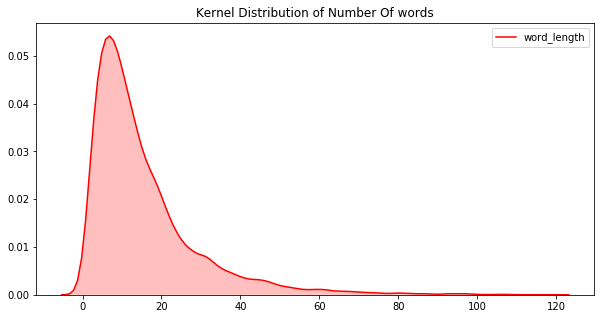

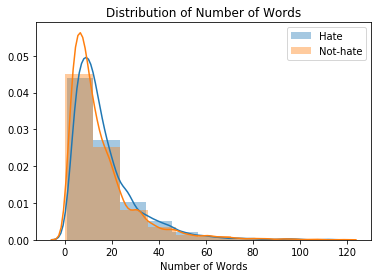

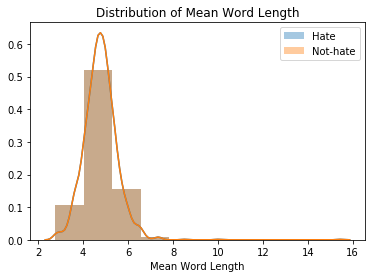

Dataset -  df_B
             label  word_length
count  6345.000000  6345.000000
mean      0.544523    12.341844
std       0.498053    16.080050
min       0.000000     1.000000
25%       0.000000     4.000000
50%       1.000000     7.000000
75%       1.000000    14.000000
max       1.000000   165.000000


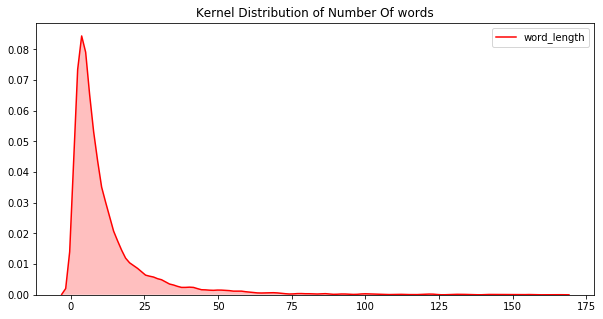

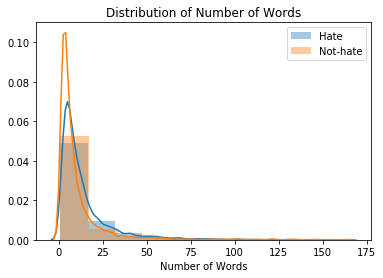

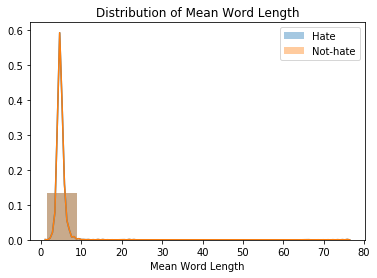

Dataset -  df_A_B
              label   word_length
count  12813.000000  12813.000000
mean       0.426676     13.936939
std        0.494614     15.015938
min        0.000000      0.000000
25%        0.000000      5.000000
50%        0.000000      9.000000
75%        1.000000     17.000000
max        1.000000    165.000000


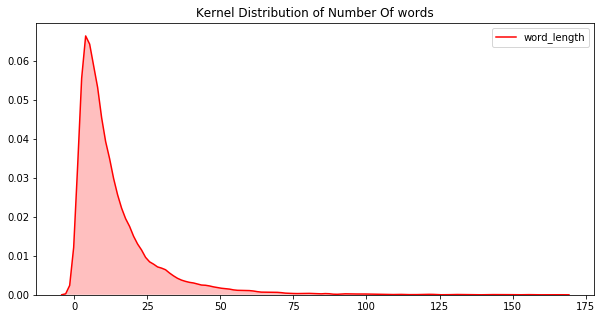

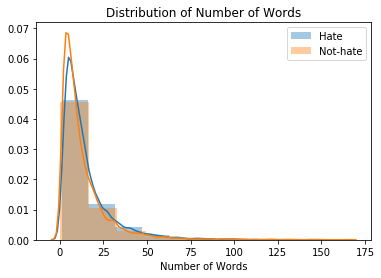

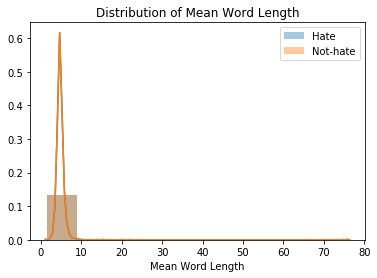

In [28]:
visualize_df_class({'df_A': df_A,'df_B': df_B,'df_A_B' :df_A_B})

# Dataset Experiment with Logistic Regression

In [11]:

def dataset_check(df_list,vectorizer,feature_name):
    
    final_result =pd.DataFrame(columns=['Accuracy','F1-score','Recall','Precision','AUC'])
    for name,df in df_list.items():
        X_train,X_test,Y_train,Y_test = prepare_dataset(df,name)
        #bow_vectorizer = CountVectorizer(analyzer="word", tokenizer=lambda text: text.split())
        lr_pipe, Y_pred = LR(X_train,X_test,Y_train,vectorizer,feature_name)
        final_result = log_result(Y_test,Y_pred,feature_name,name,final_result)
        #result_df['model'] = name
        #dfs.append(result_df)
        #final_result_df = pd.concat(dfs,ignore_index=True) #ignore_index = 
    #print(final_result)
    # log final result dataframe in neptune
    return final_result
      


## Compare feature result

### BOW

df_A 6468
X train (4527,) Y train (4527,) X test (1941,) Y test (1941,)
========= Eperiment -  df_A  -  bow  =========
Accuracy: 0.82
Auc: 0.76
Precsion: 0.79
f1_score: 0.68
recall: 0.6
Detail:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      1337
           1       0.79      0.60      0.68       604

    accuracy                           0.82      1941
   macro avg       0.81      0.76      0.78      1941
weighted avg       0.82      0.82      0.82      1941



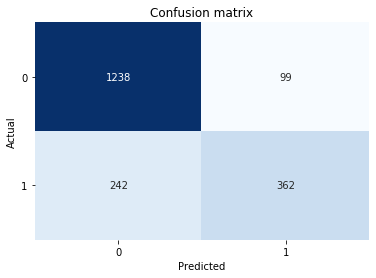

df_B 6345
X train (4441,) Y train (4441,) X test (1904,) Y test (1904,)
========= Eperiment -  df_B  -  bow  =========
Accuracy: 0.84
Auc: 0.84
Precsion: 0.88
f1_score: 0.85
recall: 0.82
Detail:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       867
           1       0.88      0.82      0.85      1037

    accuracy                           0.84      1904
   macro avg       0.84      0.84      0.84      1904
weighted avg       0.84      0.84      0.84      1904



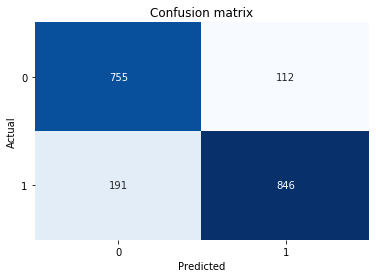

df_C 1411
X train (987,) Y train (987,) X test (424,) Y test (424,)
========= Eperiment -  df_C  -  bow  =========
Accuracy: 0.9
Auc: 0.82
Precsion: 0.87
f1_score: 0.76
recall: 0.68
Detail:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       325
           1       0.87      0.68      0.76        99

    accuracy                           0.90       424
   macro avg       0.89      0.82      0.85       424
weighted avg       0.90      0.90      0.90       424



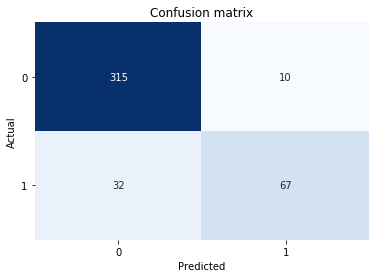

df_D 1446
X train (1012,) Y train (1012,) X test (434,) Y test (434,)
========= Eperiment -  df_D  -  bow  =========
Accuracy: 0.67
Auc: 0.66
Precsion: 0.68
f1_score: 0.59
recall: 0.51
Detail:
              precision    recall  f1-score   support

           0       0.66      0.80      0.72       235
           1       0.68      0.51      0.59       199

    accuracy                           0.67       434
   macro avg       0.67      0.66      0.65       434
weighted avg       0.67      0.67      0.66       434



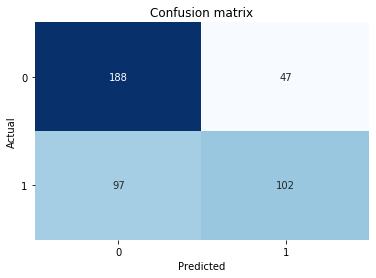

df_A_B 12813
X train (8969,) Y train (8969,) X test (3844,) Y test (3844,)
========= Eperiment -  df_A_B  -  bow  =========
Accuracy: 0.82
Auc: 0.8
Precsion: 0.84
f1_score: 0.77
recall: 0.71
Detail:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85      2204
           1       0.84      0.71      0.77      1640

    accuracy                           0.82      3844
   macro avg       0.82      0.80      0.81      3844
weighted avg       0.82      0.82      0.82      3844



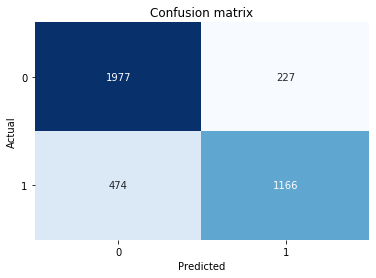

df_A_C 7879
X train (5515,) Y train (5515,) X test (2364,) Y test (2364,)
========= Eperiment -  df_A_C  -  bow  =========
Accuracy: 0.82
Auc: 0.75
Precsion: 0.77
f1_score: 0.65
recall: 0.56
Detail:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1661
           1       0.77      0.56      0.65       703

    accuracy                           0.82      2364
   macro avg       0.80      0.75      0.77      2364
weighted avg       0.82      0.82      0.81      2364



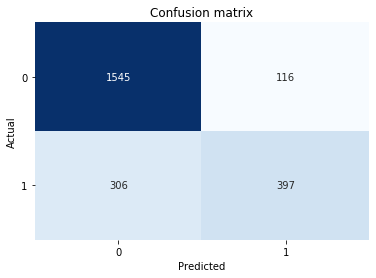

df_A_D 7914
X train (5539,) Y train (5539,) X test (2375,) Y test (2375,)
========= Eperiment -  df_A_D  -  bow  =========
Accuracy: 0.79
Auc: 0.74
Precsion: 0.76
f1_score: 0.65
recall: 0.56
Detail:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85      1572
           1       0.76      0.56      0.65       803

    accuracy                           0.79      2375
   macro avg       0.78      0.74      0.75      2375
weighted avg       0.79      0.79      0.78      2375



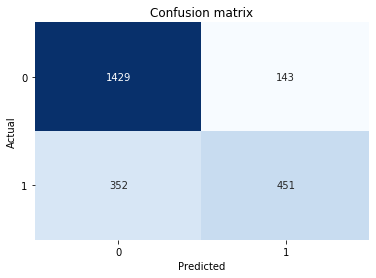

df_A_C_D 9325
X train (6527,) Y train (6527,) X test (2798,) Y test (2798,)
========= Eperiment -  df_A_C_D  -  bow  =========
Accuracy: 0.8
Auc: 0.73
Precsion: 0.76
f1_score: 0.64
recall: 0.55
Detail:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1896
           1       0.76      0.55      0.64       902

    accuracy                           0.80      2798
   macro avg       0.79      0.73      0.75      2798
weighted avg       0.79      0.80      0.79      2798



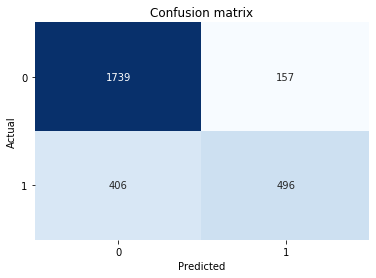

df_A_B_C 14224
X train (9956,) Y train (9956,) X test (4268,) Y test (4268,)
========= Eperiment -  df_A_B_C  -  bow  =========
Accuracy: 0.83
Auc: 0.81
Precsion: 0.84
f1_score: 0.77
recall: 0.71
Detail:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      2529
           1       0.84      0.71      0.77      1739

    accuracy                           0.83      4268
   macro avg       0.83      0.81      0.82      4268
weighted avg       0.83      0.83      0.83      4268



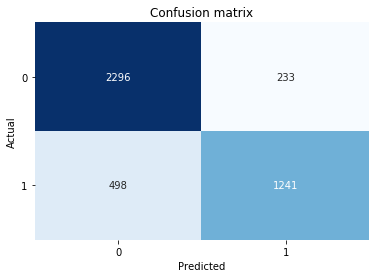

df_A_B_D 14259
X train (9981,) Y train (9981,) X test (4278,) Y test (4278,)
========= Eperiment -  df_A_B_D  -  bow  =========
Accuracy: 0.81
Auc: 0.8
Precsion: 0.83
f1_score: 0.76
recall: 0.7
Detail:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84      2439
           1       0.83      0.70      0.76      1839

    accuracy                           0.81      4278
   macro avg       0.82      0.80      0.80      4278
weighted avg       0.81      0.81      0.81      4278



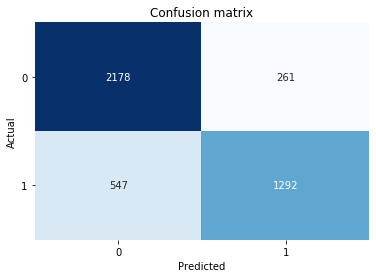

df_all 15670
X train (10969,) Y train (10969,) X test (4701,) Y test (4701,)
========= Eperiment -  df_all  -  bow  =========
Accuracy: 0.82
Auc: 0.8
Precsion: 0.83
f1_score: 0.76
recall: 0.7
Detail:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85      2763
           1       0.83      0.70      0.76      1938

    accuracy                           0.82      4701
   macro avg       0.82      0.80      0.81      4701
weighted avg       0.82      0.82      0.82      4701



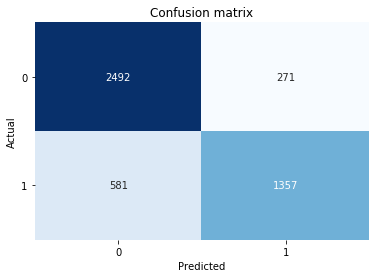

,Accuracy,F1-score,Recall,Precision,AUC
df_A,0.824317,0.679812,0.599338,0.785249,0.762646
df_B,0.840861,0.848120,0.815815,0.883090,0.843317
df_C,0.900943,0.761364,0.676768,0.870130,0.822999
df_D,0.668203,0.586207,0.512563,0.684564,0.656281
df_A_B,0.817638,0.768876,0.710976,0.837042,0.803991
df_A_C,0.821489,0.652961,0.564723,0.773879,0.747443
df_A_D,0.791579,0.645669,0.561644,0.759259,0.735338
df_A_C_D,0.798785,0.637942,0.549889,0.759571,0.733542
df_A_B_C,0.828725,0.772487,0.713629,0.841927,0.810749
df_A_B_D,0.811127,0.761792,0.702556,0.831938,0.797772


In [24]:
# bow
bow_vectorizer = CountVectorizer(analyzer="word", tokenizer=lambda text: text.split())
res_bow = dataset_check(df_dict,bow_vectorizer,'bow')
res_bow

### TFIDF

df_A 6468
X train (4527,) Y train (4527,) X test (1941,) Y test (1941,)
========= Eperiment -  df_A  -  tfidf  =========


Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-44
Accuracy: 0.8
Auc: 0.71
Precsion: 0.85
f1_score: 0.59
recall: 0.45
Detail:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87      1337
           1       0.85      0.45      0.59       604

    accuracy                           0.80      1941
   macro avg       0.82      0.71      0.73      1941
weighted avg       0.81      0.80      0.78      1941



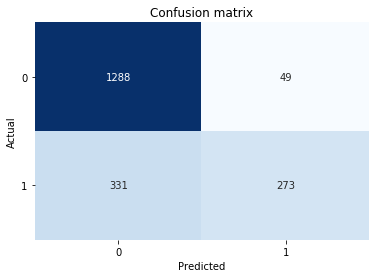

df_B 6345
X train (4441,) Y train (4441,) X test (1904,) Y test (1904,)
========= Eperiment -  df_B  -  tfidf  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-45
Accuracy: 0.85
Auc: 0.85
Precsion: 0.85
f1_score: 0.86
recall: 0.87
Detail:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       867
           1       0.85      0.87      0.86      1037

    accuracy                           0.85      1904
   macro avg       0.85      0.85      0.85      1904
weighted avg       0.85      0.85      0.85      1904



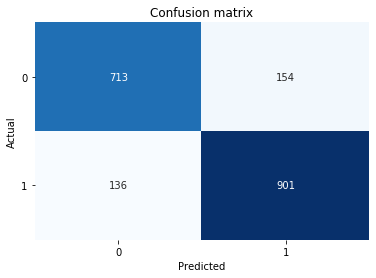

df_C 1411
X train (987,) Y train (987,) X test (424,) Y test (424,)
========= Eperiment -  df_C  -  tfidf  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-46
Accuracy: 0.82
Auc: 0.62
Precsion: 0.96
f1_score: 0.39
recall: 0.24
Detail:
              precision    recall  f1-score   support

           0       0.81      1.00      0.90       325
           1       0.96      0.24      0.39        99

    accuracy                           0.82       424
   macro avg       0.89      0.62      0.64       424
weighted avg       0.85      0.82      0.78       424



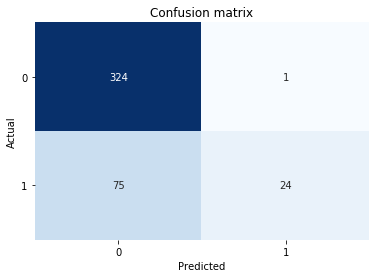

df_D 1446
X train (1012,) Y train (1012,) X test (434,) Y test (434,)
========= Eperiment -  df_D  -  tfidf  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-47
Accuracy: 0.68
Auc: 0.66
Precsion: 0.72
f1_score: 0.58
recall: 0.49
Detail:
              precision    recall  f1-score   support

           0       0.66      0.84      0.74       235
           1       0.72      0.49      0.58       199

    accuracy                           0.68       434
   macro avg       0.69      0.66      0.66       434
weighted avg       0.69      0.68      0.67       434



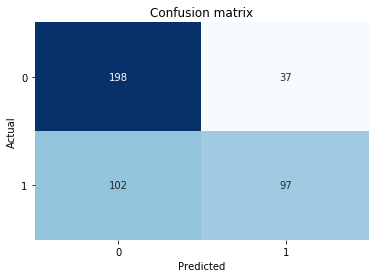

df_A_B 12813
X train (8969,) Y train (8969,) X test (3844,) Y test (3844,)
========= Eperiment -  df_A_B  -  tfidf  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-48
Accuracy: 0.82
Auc: 0.8
Precsion: 0.86
f1_score: 0.77
recall: 0.69
Detail:
              precision    recall  f1-score   support

           0       0.80      0.92      0.85      2204
           1       0.86      0.69      0.77      1640

    accuracy                           0.82      3844
   macro avg       0.83      0.80      0.81      3844
weighted avg       0.83      0.82      0.82      3844



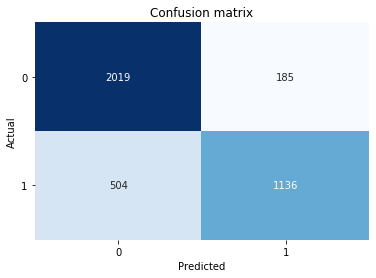

df_A_C 7879
X train (5515,) Y train (5515,) X test (2364,) Y test (2364,)
========= Eperiment -  df_A_C  -  tfidf  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-49
Accuracy: 0.8
Auc: 0.69
Precsion: 0.81
f1_score: 0.55
recall: 0.42
Detail:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87      1661
           1       0.81      0.42      0.55       703

    accuracy                           0.80      2364
   macro avg       0.80      0.69      0.71      2364
weighted avg       0.80      0.80      0.77      2364



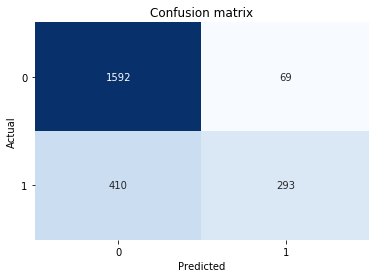

df_A_D 7914
X train (5539,) Y train (5539,) X test (2375,) Y test (2375,)
========= Eperiment -  df_A_D  -  tfidf  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-50
Accuracy: 0.77
Auc: 0.69
Precsion: 0.79
f1_score: 0.57
recall: 0.44
Detail:
              precision    recall  f1-score   support

           0       0.77      0.94      0.85      1572
           1       0.79      0.44      0.57       803

    accuracy                           0.77      2375
   macro avg       0.78      0.69      0.71      2375
weighted avg       0.78      0.77      0.75      2375



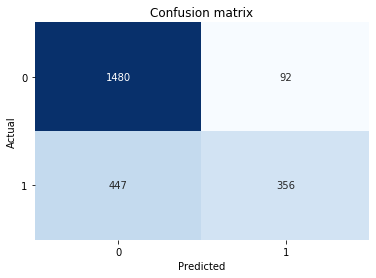

df_A_C_D 9325
X train (6527,) Y train (6527,) X test (2798,) Y test (2798,)
========= Eperiment -  df_A_C_D  -  tfidf  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-51
Accuracy: 0.78
Auc: 0.69
Precsion: 0.8
f1_score: 0.56
recall: 0.43
Detail:
              precision    recall  f1-score   support

           0       0.78      0.95      0.85      1896
           1       0.80      0.43      0.56       902

    accuracy                           0.78      2798
   macro avg       0.79      0.69      0.71      2798
weighted avg       0.78      0.78      0.76      2798



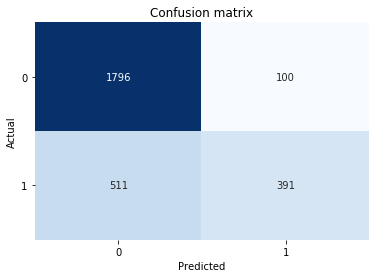

df_A_B_C 14224
X train (9956,) Y train (9956,) X test (4268,) Y test (4268,)
========= Eperiment -  df_A_B_C  -  tfidf  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-52
Accuracy: 0.82
Auc: 0.8
Precsion: 0.86
f1_score: 0.76
recall: 0.68
Detail:
              precision    recall  f1-score   support

           0       0.81      0.93      0.86      2529
           1       0.86      0.68      0.76      1739

    accuracy                           0.82      4268
   macro avg       0.84      0.80      0.81      4268
weighted avg       0.83      0.82      0.82      4268



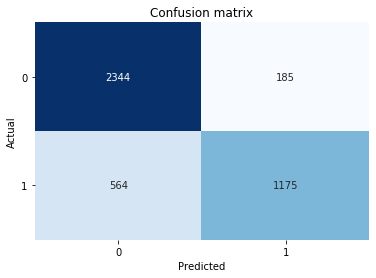

df_A_B_D 14259
X train (9981,) Y train (9981,) X test (4278,) Y test (4278,)
========= Eperiment -  df_A_B_D  -  tfidf  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-53
Accuracy: 0.81
Auc: 0.8
Precsion: 0.85
f1_score: 0.76
recall: 0.68
Detail:
              precision    recall  f1-score   support

           0       0.79      0.91      0.85      2439
           1       0.85      0.68      0.76      1839

    accuracy                           0.81      4278
   macro avg       0.82      0.80      0.80      4278
weighted avg       0.82      0.81      0.81      4278



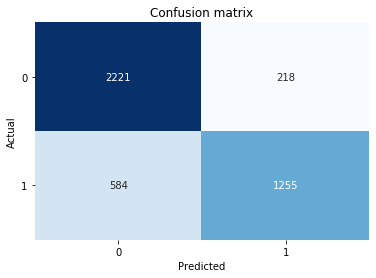

df_all 15670
X train (10969,) Y train (10969,) X test (4701,) Y test (4701,)
========= Eperiment -  df_all  -  tfidf  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-54
Accuracy: 0.81
Auc: 0.79
Precsion: 0.85
f1_score: 0.74
recall: 0.66
Detail:
              precision    recall  f1-score   support

           0       0.79      0.92      0.85      2763
           1       0.85      0.66      0.74      1938

    accuracy                           0.81      4701
   macro avg       0.82      0.79      0.80      4701
weighted avg       0.82      0.81      0.81      4701



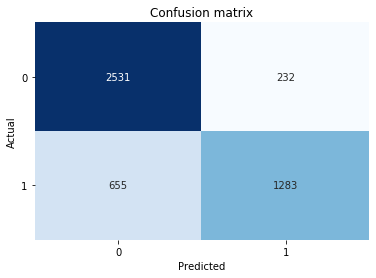

NameError: name 'res_tfidf' is not defined

In [13]:
# bow
tfidf_vectorizer = TfidfVectorizer(analyzer="word", tokenizer=lambda text: text.split())
res_tdidf = dataset_check(df_dict,tfidf_vectorizer,'tfidf')
res_tdidf

In [14]:
res_tdidf

,Accuracy,F1-score,Recall,Precision,AUC
df_A,0.804225,0.589633,0.451987,0.847826,0.707669
df_B,0.847689,0.861377,0.868852,0.854028,0.845614
df_C,0.820755,0.387097,0.242424,0.960000,0.619674
df_D,0.679724,0.582583,0.487437,0.723881,0.664995
df_A_B,0.820760,0.767308,0.692683,0.859955,0.804372
df_A_C,0.797377,0.550235,0.416785,0.809392,0.687622
df_A_D,0.773053,0.569145,0.443337,0.794643,0.692407
df_A_C_D,0.781630,0.561378,0.433481,0.796334,0.690369
df_A_B_C,0.824508,0.758309,0.675676,0.863971,0.801262
df_A_B_D,0.812529,0.757850,0.682436,0.852003,0.796528


Unexpected error in ping thread.
Traceback (most recent call last):
  File "C:\Users\Kavishka\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "C:\Users\Kavishka\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 421, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Users\Kavishka\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 416, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Users\Kavishka\anaconda3\lib\http\client.py", line 1344, in getresponse
    response.begin()
  File "C:\Users\Kavishka\anaconda3\lib\http\client.py", line 306, in begin
    version, status, reason = self._read_status()
  File "C:\Users\Kavishka\anaconda3\lib\http\client.py", line 267, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Users\Kavishka\anaconda3\lib\socket.py", line 589, in readinto
    return self._sock.recv_into

## word embedding

In [ ]:
# word2vec - word embeding
from gensim.models import Word2Vec

word_emb_model = Word2Vec.load('word2vec.bin')
dataset_check(df_list,word_emb_model,'word2vec')
# build word2vec model
model = gensim.models.Word2Vec(tokenized_train,
                               vector_size=300,
                               window=100,
                               min_count=30,
                               sample=1e-3)
model.save('../Embedding_models/word2vec')
new_model = gensim.models.Word2Vec.load('/tmp/mymodel')
#model.train(more_sentences)
# averaged word vector features
avg_wv_train_features = averaged_word_vectorizer(corpus=tokenized_train,
                                                 model=model.wv,
                                                 num_features=300)
avg_wv_test_features = averaged_word_vectorizer(corpus=tokenized_test,
                                                model=model.wv,
                                                num_features=300)

In [ ]:


model.wv.most_similar('virus')



In [ ]:
def average_word_vectors(words, model, vocabulary, num_features):

    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector
    
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.index_to_key)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                for tokenized_sentence in corpus]
    return np.array(features)

In [ ]:
# tfidf weighted averaged word vector features
vocab = tfidf_vectorizer.vocabulary_
tfidf_wv_train_features = tfidf_weighted_averaged_word_vectorizer(corpus=tokenized_train,
                                                                  tfidf_vectors=tfidf_train_features,
                                                                  tfidf_vocabulary=vocab,
                                                                  model=model.wv,
                                                                  num_features=300)
tfidf_wv_test_features = tfidf_weighted_averaged_word_vectorizer(corpus=tokenized_test,
                                                                 tfidf_vectors=tfidf_test_features,
                                                                 tfidf_vocabulary=vocab,
                                                                 model=model.wv,
                                                                 num_features=300)

## Compare Results

In [37]:
# dataset name list

df_dict = {'df_A': df_A,'df_B': df_B,'df_C' :df_C,'df_D' :df_D,'df_A_B' :df_A_B,'df_A_C' :df_A_C,'df_A_D' :df_A_D,'df_A_C_D':df_A_C_D,'df_all':df_all}
dataset_check(df_dict)

df_A 6468
X train (4527,) Y train (4527,) X test (1941,) Y test (1941,)
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-14
(1941,) (1941,)
              precision    recall  f1-score      support
0              0.816099  0.931988  0.870202  1338.000000
1              0.779661  0.533997  0.633858   603.000000
accuracy       0.808346  0.808346  0.808346     0.808346
macro avg      0.797880  0.732992  0.752030  1941.000000
weighted avg   0.804779  0.808346  0.796779  1941.000000
df_B 6345
X train (4441,) Y train (4441,) X test (1904,) Y test (1904,)
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-15
(1904,) (1904,)
              precision    recall  f1-score      support
0              0.792531  0.879171  0.833606   869.000000
1              0.888298  0.806763  0.845570  1035.000000
accuracy       0.839811  0.839811  0.839811     0.839811
macro avg      0.840414  0.842967  0.839588  1904.000000
weighted avg   0.844589  0.839811  0.840109  1904.000000
df_C 1411
X tr

,precision,recall,f1-score,support,model
0,0.816099,0.931988,0.870202,1338.000000,df_A
1,0.779661,0.533997,0.633858,603.000000,df_A
2,0.808346,0.808346,0.808346,0.808346,df_A
3,0.797880,0.732992,0.752030,1941.000000,df_A
4,0.804779,0.808346,0.796779,1941.000000,df_A
5,0.792531,0.879171,0.833606,869.000000,df_B
6,0.888298,0.806763,0.845570,1035.000000,df_B
7,0.839811,0.839811,0.839811,0.839811,df_B
8,0.840414,0.842967,0.839588,1904.000000,df_B
9,0.844589,0.839811,0.840109,1904.000000,df_B


Unexpected error in ping thread.
Traceback (most recent call last):
  File "C:\Users\Kavishka\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "C:\Users\Kavishka\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 421, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Users\Kavishka\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 416, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Users\Kavishka\anaconda3\lib\http\client.py", line 1344, in getresponse
    response.begin()
  File "C:\Users\Kavishka\anaconda3\lib\http\client.py", line 306, in begin
    version, status, reason = self._read_status()
  File "C:\Users\Kavishka\anaconda3\lib\http\client.py", line 267, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Users\Kavishka\anaconda3\lib\socket.py", line 589, in readinto
    return self._sock.recv_into

## Adversarial validation to evaluate dataset distribution 
Each dataset compared with Main dataset Gossipsite dataset

In [29]:
display(df_A.head())
display(df_B.head())

,comment,label,df,cleaned
0,මේ වේසිට නීතිය ක්‍රියාත්මක වෙන්නෙ කවදාද ?,1,A,මේ වේසිට නීතිය ක්‍රියාත්මක වෙන්නෙ කවදාද
1,තූ ෙනදකින්,1,A,තූ ෙනදකින්
2,අම්මා ලුසීඩා කියුවම මට හිතෙන්නම ෆලූඩා කියලා. හ...,0,A,අම්මා ලුසීඩා කියුවම මට හිතෙන්නම ෆලූඩා කියලා හ...
3,දින ඒකාබද්ධ විපක්ෂයේ මාධ්‍ය ලේකම් රේණුක පෙරේරා...,0,A,දින ඒකාබද්ධ විපක්ෂයේ මාධ්‍ය ලේකම් රේණුක පෙරේරා...
4,පූදින්ෙන නැතුව ඉදිං,1,A,පූදින්ෙන නැතුව ඉදිං


,comment,label,df,cleaned
0,`හුදෙකලා´ එකේ `ද´ ඇහෙනවද කාටහරි,0,B,`හුදෙකලා එකේ `ද ඇහෙනවද කාටහරි
1,18ක පෙනුමක් තියෙන්නේ,0,B,ක පෙනුමක් තියෙන්නේ
2,2020 එනවා කිව්නාට මෙහෙම එයි කියලා හිතුවේ නෑ පට්ට,0,B,එනවා කිව්නාට මෙහෙම එයි කියලා හිතුවේ නෑ පට්ට
3,25 කැල්ල..හම්මෝ..,0,B,කැල්ල හම්මෝ
4,25 කෙල්ල අයියලගෙ කාලද කොහෙද ඉන්නෙ,1,B,කෙල්ල අයියලගෙ කාලද කොහෙද ඉන්නෙ


In [30]:
# Adverserial Validation
from scipy import sparse
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold


def adversarial_validation(X, Y, n_splits = 10):
    
    # Combine both datasets
    sparse_merge = sparse.vstack((X, Y))
    
    # Label the datasets
    y = np.array([0 for _ in range(X.shape[0])] + [1 for _ in range(Y.shape[0])])
    
    # Do 10 Fold CV 
    kfold = StratifiedKFold(n_splits = n_splits, shuffle = True)

    lr_auc = np.array([])
    rf_auc = np.array([])
    for train_idx, test_idx in kfold.split(sparse_merge, y):
    
        #Run Log Reg
        x_train, y_train = sparse_merge[train_idx], y[train_idx]
        x_test, y_test = sparse_merge[test_idx], y[test_idx]
        
        log_reg = SGDClassifier(loss = 'log')
        log_reg.fit(x_train, y_train)
        y_test_prob = log_reg.predict_proba(x_test)[:,1]
        lr_auc = np.append(lr_auc, roc_auc_score(y_test, y_test_prob))
        # Run RF
        rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1)
        rf.fit(x_train, y_train)
        y_test_prob = rf.predict_proba(x_test)[:,1]
        rf_auc = np.append(rf_auc, roc_auc_score(y_test, y_test_prob))

    
    # Display results
    print('Logisitic Regression AUC : {:.3f}'.format(lr_auc.mean()))
    print('Random Forest AUC : {:.3f}'.format(rf_auc.mean()))

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle 

bow = CountVectorizer()
df1 = bow.fit_transform(df_A.cleaned.values)
df2 = bow.transform(.values)

df2 = shuffle(df2)

adversarial_validation(df1, df2)

In [36]:
from sklearn.model_selection import cross_validate,cross_val_predict
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import *
lr_clf = LogisticRegression()
bow_vectorizer = CountVectorizer(analyzer="word", tokenizer=lambda text: text.split())
from sklearn.pipeline import Pipeline
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score),
           'AUC':make_scorer(roc_auc_score)
           }

pipeline = Pipeline([
    ('transformer', bow_vectorizer),
    ('classifier', lr_clf)
])
X, Y =shuffle(df_A.cleaned, df_A.label,random_state = 0)
cv_results = cross_validate(pipeline, X, Y, cv=5,scoring=scoring )
print(cv_results)
# y_pred = cross_val_predict(clf, X_train, y_train, cv=3)
# conf_mat = confusion_matrix(y, y_pred)

{'fit_time': array([2.09938765, 1.21275568, 0.97538781, 0.6991291 , 0.671206  ]), 'score_time': array([0.14960241, 0.11270189, 0.07679486, 0.06781816, 0.06981158]), 'test_accuracy': array([0.82612056, 0.81684699, 0.80834621, 0.83062645, 0.83294664]), 'test_precision': array([0.81494662, 0.79225352, 0.76816609, 0.81443299, 0.81632653]), 'test_recall': array([0.56965174, 0.55831266, 0.55086849, 0.58955224, 0.59701493]), 'test_f1_score': array([0.67057101, 0.65502183, 0.6416185 , 0.68398268, 0.68965517]), 'test_AUC': array([0.75567789, 0.74604746, 0.73783604, 0.76447309, 0.76820443])}


In [39]:
from sklearn.model_selection import cross_validate,cross_val_predict
y_pred = cross_val_predict(pipeline, X,Y, cv=5)
print(Y_pred)
print(y_pred.shape)
#conf_mat = confusion_matrix(y, y_pred)
#result(y_test, y_pred)

NameError: name 'Y_pred' is not defined

In [ ]:
kfold = KFold(3, shuffle=True, random_state=33)
i = 1
for train_idx, test_idx in kfold.split(X):
    X_train = X[train_idx]
    y_train = y[train_idx]

    X_test = X[test_idx]
    y_test = y[test_idx]

    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    model = LinearSVC()
    model.fit(X_train, y_train)
    print ("Fold : {0}".format(i))
    i += 1
    print (classification_report(y_test, model.predict(X_test)))

In [ ]:
# cross validation and get confusion matrix
def confusion_matrix_scorer(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    return {'tn': cm[0, 0], 'fp': cm[0, 1],
            'fn': cm[1, 0], 'tp': cm[1, 1]}
cv_results = cross_validate(svm, X, y, cv=5,
                            scoring=confusion_matrix_scorer)

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(clf, x, y, cv=5)
cm = confusion_matrix(y, y_pred)

In [ ]:
# 
cross_validate(pipeline,x,y)
 Y=cross_pred_
 confusion matrix
